In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines
import re
import glob
import csv
import warnings
import urllib.request
import statistics
import xlrd
import io
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,silhouette_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from io import StringIO
%matplotlib inline

In [ ]:
#--------------------------------------------------------------------------------------
# Automated Download of Data
#--------------------------------------------------------------------------------------

# First read the stations file
stations=pd.read_csv(r'C:\Users\USER\Desktop\assign3data\stations.txt',header=None)
stations
stations.columns=(['station_name'])
stations_list=stations['station_name'].to_list()
stations_list

# Download data from the given link and create separate files for each station(from above file)
print('Beginning file download with urllib2...')

# You can get the user_agent by typing user_agent in your browser
# This is to avoid the 404 error
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.113 Safari/537.36'

#Read the data from the URL,save to csv files
for station_name in stations_list:
        url = "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/"+station_name+"data.txt"
        headers={'User-Agent':user_agent,} 
        request=urllib.request.Request(url,None,headers) 
        response = urllib.request.urlopen(request)
        data = response.read() #data is of bytes type
        s=str(data)
        data = StringIO(s) 
        clean_data=pd.DataFrame(data) #Convert to Dataframe
        clean_data.to_csv(r"C:\Users\USER\Desktop\assign3data\automated_download_data\\"+station_name+"data.txt")
        

In [ ]:
#--------------------------------------------------------------------------------------
# Reading the files for the clustering and classification tasks
#--------------------------------------------------------------------------------------
# Path where you have the downloaded data

path =r'C:\Users\USER\Desktop\assign3data\weather_data' # Here,I gave the manually downloaded data path

filenames = glob.glob("*.txt")

dfs=[]
#Print filenames and give total number of files
for filename in filenames:
    print(filename)
    df=pd.read_csv(filename, delim_whitespace=True,error_bad_lines=False,skiprows=7,warn_bad_lines=False)
    dfs.append(df)
print('total number of files:',len(dfs))   

In [ ]:
#--------------------------------------------------------------------------------------
# Data Cleaning for tasks-Clustering and Classification
#--------------------------------------------------------------------------------------
diff_files={r"braemardata.txt",r"whitbydata.txt",
            r"lowestoftdata.txt",r"nairndata.txt"
            ,r"southamptondata.txt"}

filenames = [i for i in filenames if i not in diff_files]
clean_data=[]

for filename in filenames:
    print(filename)
    missing_values = ["n/a", "na", "---","  "]
    data= pd.read_csv(filename,delim_whitespace=True,error_bad_lines=False,skiprows=7, na_values = missing_values,warn_bad_lines=False)
    data.columns=(['year','month','tmax','tmin','airfrost_days','total_rain','total_sunhours'])
    data= data.replace('[^0-9.\-]','',regex=True)
    data = data.astype({"tmax": float, "tmin": float,"airfrost_days":float,"total_rain":float,"total_sunhours":float})
    data.isnull().any()
    #"""
    data=data.dropna(subset=['year','month','tmax','tmin'])
    data['airfrost_days']=data['airfrost_days'].fillna(data['airfrost_days'].mean())
    data['total_rain']=data['total_rain'].fillna(data['total_rain'].mean())
    data['total_sunhours']=data['total_sunhours'].fillna(data['total_sunhours'].mean())
    #"""
    #data=data.dropna()

    """
    # Handling Outliers------------------------------------------------------------------------
    box=data.drop(['year','month'],axis=1)
    b=np.array(box)
    fig, ax = plt.subplots(figsize=(5,5))
    plt.boxplot(b[:,:5],ax)
    plt.show()
    Q1=data.quantile(0.25)
    Q3=data.quantile(0.75)
    IQR=Q3-Q1
    df_out = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(df_out)
    print(df_out.shape)
    data=pd.DataFrame(df_out)
    #-------------------------------------------------------------------------------------------
    """

    fname = filename
    data['class']=fname.replace("data.txt","")
    data=data.round(decimals=2)
    """
    #---------------------------------------------------------------------------------------------------------------
    #Classification task block
    latdata=pd.read_csv(filename,nrows=1,skiprows=0,delim_whitespace=True,error_bad_lines=False,warn_bad_lines=False)
    #print(latdata)
    a=latdata.to_string(header=False)
    #print(a)
    #print(type(a))
    m = re.search('Lat (.+?) Lon',a)
    if m:
        lat = m.group(1)
        #print(lat)
    data['latitude']=lat
    #----------------------------------------------------------------------------------------------------------------
    """
    print(data.head())
    clean_data.append(data)
    clean_data_df=pd.concat(clean_data,axis=0,ignore_index=False)
clean_data_df.info()
print('First five rows of Cleaned data are:\n',clean_data_df.head())
clean_data_df.to_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\cleaned_data\cleaned_imputed_data.txt',sep='\t',header=True,index=False)


In [ ]:
#--------------------------------------------------------------------------------------
# Data Cleaning for tasks-Clustering and Classification
#--------------------------------------------------------------------------------------

for filename in {r"braemardata.txt",
            r"lowestoftdata.txt",r"nairndata.txt"
            ,r"southamptondata.txt"}:
    print(filename)
    missing_values = ["n/a", "na", "---","  "]
    data= pd.read_csv(filename,delim_whitespace=True,error_bad_lines=False,skiprows=8, na_values = missing_values,warn_bad_lines=False)
    data.columns=(['year','month','tmax','tmin','airfrost_days','total_rain','total_sunhours'])
    data= data.replace('[^0-9.\-]','',regex=True)
    data = data.astype({"tmax": float, "tmin": float,"airfrost_days":float,"total_rain":float,"total_sunhours":float})
    data.isnull().any()
    #"""
    data=data.dropna(subset=['year','month','tmax','tmin'])
    data['airfrost_days']=data['airfrost_days'].fillna(data['airfrost_days'].mean())
    data['total_rain']=data['total_rain'].fillna(data['total_rain'].mean())
    data['total_sunhours']=data['total_sunhours'].fillna(data['total_sunhours'].mean())
    #"""
    #data=data.dropna()
    """
    # Handling Outliers--------------------------------------------------------------------
    box=data.drop(['year','month'],axis=1)
    b=np.array(box)
    fig, ax = plt.subplots(figsize=(5,5))
    plt.boxplot(b[:,:5],ax)
    plt.show()
    Q1=data.quantile(0.25)
    Q3=data.quantile(0.75)
    IQR=Q3-Q1
    df_out = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(df_out)
    print(df_out.shape)
    data=pd.DataFrame(df_out)
    #---------------------------------------------------------------------------------------
    """
    fname = filename
    data['class']=fname.replace("data.txt","")
    data=data.round(decimals=2)
    """
    #---------------------------------------------------------------------------------------------------------------
    #Classification task block
    latdata=pd.read_csv(filename,nrows=1,skiprows=0,delim_whitespace=True,error_bad_lines=False,warn_bad_lines=False)
    #print(latdata)
    a=latdata.to_string(header=False)
    #print(a)
    #print(type(a))
    m = re.search('Lat (.+?) Lon',a)
    if m:
        lat = m.group(1)
        #print(lat)
    data['latitude']=lat
    #----------------------------------------------------------------------------------------------------------------
    """
    print(data.head())
    clean_data.append(data)
    clean_data_df=pd.concat(clean_data,ignore_index=False)
print('First five rows of Cleaned data are:\n',clean_data_df.head())
clean_data_df.to_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\cleaned_data\cleaned_imputed_data.txt',sep='\t',header=True,index=False)
    
    


In [ ]:
#--------------------------------------------------------------------------------------
# Data Cleaning for tasks-Clustering and Classification
#--------------------------------------------------------------------------------------
for filename in {r"whitbydata.txt"}:
    print(filename)
    missing_values = ["n/a", "na", "---","  "]
    data= pd.read_csv(filename,delim_whitespace=True,error_bad_lines=False,skiprows=6, na_values = missing_values,warn_bad_lines=False)
    data.columns=(['year','month','tmax','tmin','airfrost_days','total_rain','total_sunhours'])
    data=data.drop(data.index[0])
    data= data.replace('[^0-9.\-]','',regex=True)
    data = data.astype({"tmax": float, "tmin": float,"airfrost_days":float,"total_rain":float,"total_sunhours":float})
    data.isnull().any()
    #"""
    data=data.dropna(subset=['year','month','tmax','tmin'])
    data['airfrost_days']=data['airfrost_days'].fillna(data['airfrost_days'].mean())
    data['total_rain']=data['total_rain'].fillna(data['total_rain'].mean())
    data['total_sunhours']=data['total_sunhours'].fillna(data['total_sunhours'].mean())
    #"""
    #data=data.dropna()
    """
    # Handling Outliers--------------------------------------------------------------------
    box=data.drop(['year','month'],axis=1)
    b=np.array(box)
    fig, ax = plt.subplots(figsize=(5,5))
    plt.boxplot(b[:,:5],ax)
    plt.show()
    Q1=data.quantile(0.25)
    Q3=data.quantile(0.75)
    IQR=Q3-Q1
    df_out = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(df_out)
    print(df_out.shape)
    data=pd.DataFrame(df_out)
    #---------------------------------------------------------------------------------------
    """
    fname = filename
    data['class']=fname.replace("data.txt","")
    data=data.round(decimals=2)
    """
    #---------------------------------------------------------------------------------------------------------------
    #Part-2-Classification task block
    latdata=pd.read_csv(filename,nrows=1,skiprows=0,delim_whitespace=True,error_bad_lines=False,warn_bad_lines=False)
    #print(latdata)
    a=latdata.to_string(header=False)
    #print(a)
    #print(type(a))
    m = re.search('Lat (.+?) Lon',a)
    if m:
        lat = m.group(1)
        #print(lat)
    data['latitude']=lat
    #----------------------------------------------------------------------------------------------------------------
    """
    print(data.head())
    clean_data.append(data)
    clean_data_df=pd.concat(clean_data,ignore_index=False)
print('First five rows of Cleaned data are:\n',clean_data_df.head())
clean_data_df.to_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\cleaned_data\cleaned_imputed_data.txt',sep='\t',header=True,index=False)


In [ ]:
#--------------------------------------------------------------------------------
# PART-1
#--------------------------------------------------------------------------------

In [2]:
#--------------------------------------------------------------------------------------
# Ideal clustering approach
#--------------------------------------------------------------------------------------
#Load the cleaned data into a dataframe
asd=pd.read_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\Cleaned_data\cleaned_weather_data.txt', sep='\t')
asd
asd['class']
asd['class'].unique()
asd['class'].count()
asd.info()
asd.corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26711 entries, 0 to 26710
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            26711 non-null  int64  
 1   month           26711 non-null  int64  
 2   tmax            26711 non-null  float64
 3   tmin            26711 non-null  float64
 4   airfrost_days   26711 non-null  float64
 5   total_rain      26711 non-null  float64
 6   total_sunhours  26711 non-null  float64
 7   class           26711 non-null  object 
dtypes: float64(5), int64(2), object(1)
memory usage: 1.6+ MB


,year,month,tmax,tmin,airfrost_days,total_rain,total_sunhours
year,1.000000,-0.001194,0.060470,0.078453,-0.044494,0.068088,0.042193
month,-0.001194,1.000000,0.246678,0.316962,-0.260834,0.156011,-0.088021
tmax,0.060470,0.246678,1.000000,0.941661,-0.728156,-0.178634,0.756515
tmin,0.078453,0.316962,0.941661,1.000000,-0.795196,-0.067672,0.632691
airfrost_days,-0.044494,-0.260834,-0.728156,-0.795196,1.000000,-0.003468,-0.484960
total_rain,0.068088,0.156011,-0.178634,-0.067672,-0.003468,1.000000,-0.366613
total_sunhours,0.042193,-0.088021,0.756515,0.632691,-0.484960,-0.366613,1.000000


In [84]:
# Grouping data to get representative data
x_try=asd.drop(['year','month'],axis=1)
x_try.info()
x_try=x_try.groupby('class')['tmax','tmin','airfrost_days','total_rain','total_sunhours'].mean().reset_index()
x_try.info()
x_try.head()
x_try   # has the representative data for each station
#sns.pairplot(x_try,hue='class') #pairplots for data visualization
#x_try = pd.get_dummies(x_try, columns=['class'])
#Cat encoding
#x_try['class']=x_try['class'].astype('category')
#x_try['class_code']=x_try['class'].cat.codes
le = LabelEncoder()
x_try['class_code'] = le.fit_transform(x_try['class'])
x_try.head()
x_try.info()
x_try=x_try.drop(['class'],axis=1)
warnings.filterwarnings('ignore')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26711 entries, 0 to 26710
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tmax            26711 non-null  float64
 1   tmin            26711 non-null  float64
 2   airfrost_days   26711 non-null  float64
 3   total_rain      26711 non-null  float64
 4   total_sunhours  26711 non-null  float64
 5   class           26711 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class           35 non-null     object 
 1   tmax            35 non-null     float64
 2   tmin            35 non-null     float64
 3   airfrost_days   35 non-null     float64
 4   total_rain      35 non-null     float64
 5   total_sunhours  35 non-null     float64
dtypes: float64(5)

C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.



 for number of clusters= 2
Cluster labels are: [1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1]
Total number of cluster labels- 35
silhouette score is: 0.508632771152883
Inertia is: {2: 17359.1425419616}

 for number of clusters= 3
Cluster labels are: [0 0 0 0 0 1 0 2 2 1 1 2 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1]
Total number of cluster labels- 35
silhouette score is: 0.4114760921431506
Inertia is: {2: 17359.1425419616, 3: 10989.58057876284}

 for number of clusters= 4
Cluster labels are: [1 3 3 3 2 1 2 0 0 3 1 0 1 1 2 1 1 1 3 3 1 2 3 1 3 3 1 2 3 2 1 1 1 3 1]
Total number of cluster labels- 35
silhouette score is: 0.34352709173302837
Inertia is: {2: 17359.1425419616, 3: 10989.58057876284, 4: 8388.251262683403}

 for number of clusters= 5
Cluster labels are: [4 2 2 2 4 0 4 3 3 2 4 3 0 4 1 0 0 0 2 2 0 1 2 0 0 2 0 1 0 1 0 0 0 2 0]
Total number of cluster labels- 35
silhouette score is: 0.3637220402449879
Inertia is: {2: 17359.1425419616, 3: 10989.580578762

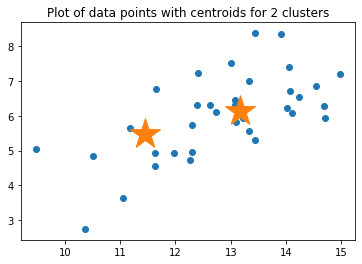

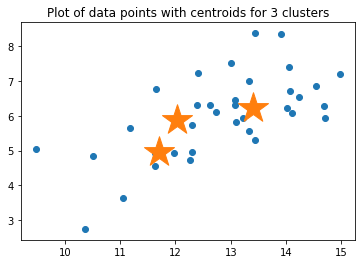

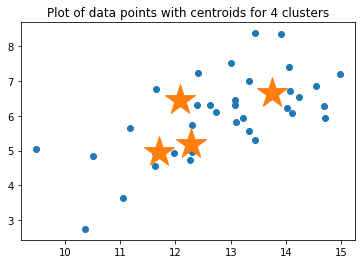

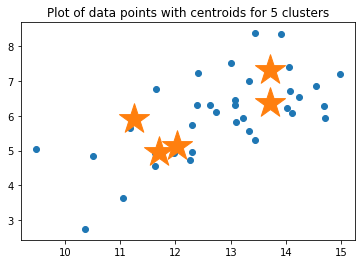

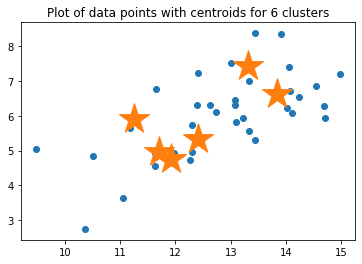

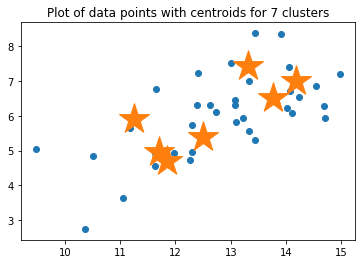

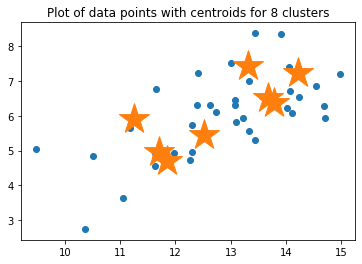

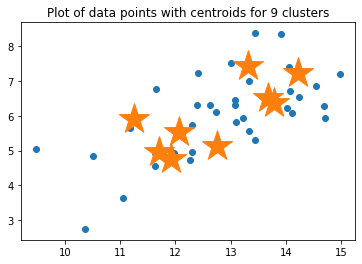

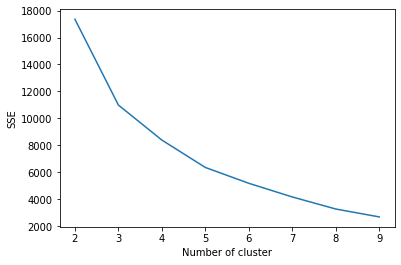

In [11]:
# K means clustering on un-scaled data
#range_n_clusters = [2, 3, 4, 5, 6,7,8]
sse={}
for n_clusters in range(2,10):
    print('\n for number of clusters=',n_clusters)
    kmeans = KMeans(n_clusters, random_state=1000)  
    model=kmeans.fit(x_try)
    cluster_labels=kmeans.predict(x_try)
    c=kmeans.cluster_centers_
    #print('\n cluster centers are',c)
    print('Cluster labels are:',cluster_labels)
    print('Total number of cluster labels-',len(cluster_labels))
    sil=silhouette_score(x_try,cluster_labels,metric='euclidean',sample_size=len(x_try))
    sse[n_clusters]=kmeans.inertia_
    print('silhouette score is:',sil)
    print('Inertia is:',sse)
    x=np.array(x_try)
    #Cluster plot
    fig=plt.figure()
    plt.scatter(x[:,0],x[:,1])
    plt.scatter(c[:,0],c[:,1],marker='*',s=1000)
    plt.title('Plot of data points with centroids for {} clusters'.format(n_clusters))
    
#Plot line graph for low SSE for different values of n_clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [12]:
# K means clustering on scaled and normalized data
names = x_try.columns
# Create the Scaler object
scaler =StandardScaler()
# Fit data on the scaler object
scaled_df = scaler.fit_transform(x_try)
scaled_df = pd.DataFrame(scaled_df, columns=names)
normalized_df=normalize(scaled_df)

range_n_clusters = [2, 3, 4, 5, 6,7,8]

for n_clusters in range_n_clusters:
    print('\n for number of clusters=',n_clusters)
    kmeans = KMeans(n_clusters, random_state=1000)  
    model=kmeans.fit(normalized_df)
    cluster_labels=kmeans.predict(normalized_df)
    c=kmeans.cluster_centers_
    print('\n cluster centers are',c)
    print('Cluster labels are:',cluster_labels)
    print('Total number of cluster labels-',len(cluster_labels))
    sil=silhouette_score(normalized_df,cluster_labels,metric='euclidean',sample_size=len(normalized_df))
    print('silhouette score is:',sil)
    print('Inertia is:',kmeans.inertia_)


 for number of clusters= 2

 cluster centers are [[-0.31979837 -0.31435219  0.18367524  0.1393534  -0.36641484 -0.12730437]
 [ 0.31464679  0.24467404 -0.14767641 -0.22506555  0.25363193  0.18655879]]
Cluster labels are: [1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1]
Total number of cluster labels- 35
silhouette score is: 0.3098074991917196
Inertia is: 22.394305742481823

 for number of clusters= 3

 cluster centers are [[ 0.28190466  0.15287334 -0.09037101 -0.28167009  0.12761595  0.5743803 ]
 [-0.31979837 -0.31435219  0.18367524  0.1393534  -0.36641484 -0.12730437]
 [ 0.35830297  0.36707498 -0.22408361 -0.14959283  0.42165325 -0.33053655]]
Cluster labels are: [2 1 1 1 2 2 2 1 1 1 2 1 2 2 1 1 2 2 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0]
Total number of cluster labels- 35
silhouette score is: 0.27527994790697874
Inertia is: 17.290663193123002

 for number of clusters= 4

 cluster centers are [[ 0.34551249  0.19558481 -0.10385392 -0.33255015  0.17180836  0.5952086 ]
 

[4 0 0 0 4 2 4 3 3 2 1 3 2 1 0 2 2 1 2 0 2 0 0 2 2 0 2 0 2 0 2 2 2 0 2]

silhouette score is: 0.02005295107604457


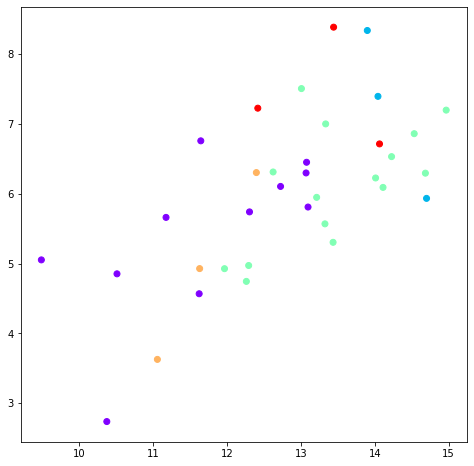

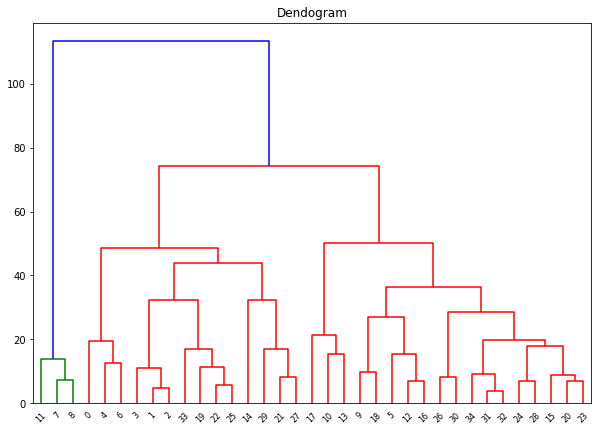

In [13]:
# Hierarchical clustering on unscaled data

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
y_pred=cluster.fit_predict(x_try)
print(cluster.labels_)
sil=silhouette_score(x_try,cluster_labels,metric='euclidean',sample_size=len(x_try),random_state=1000)
print('\nsilhouette score is:',sil)
a=np.array(x_try)
plt.figure(figsize=(8, 8))
plt.scatter(a[:,0],a[:,1], c=cluster.labels_, cmap='rainbow')
plt.show()

plt.figure(figsize=(10,7))
plt.title("Dendogram")
dend = dendrogram(linkage(x_try, method='complete'))


In [52]:
# Clustering with 2 features-tmax,tmin
f1=x_try['tmax'].values
f2=x_try['tmin'].values
f3=x_try['class_code'].values
X1=np.array(list(zip(f1,f2,f3)))


for n_clusters in range(2,10):
    print('for number of clusters=',n_clusters)
    kmeans=KMeans(n_clusters=5,random_state=1000)
    model=kmeans.fit(X1)
    cluster_labels=kmeans.predict(X1)
    sil=silhouette_score(X1,cluster_labels,metric='euclidean',sample_size=len(X1),random_state=1000)
    c2=kmeans.cluster_centers_
    print('silhouette score is:',sil)
    print('Inertia is:',kmeans.inertia_)
    #print('cluster centers are',c2)
    print('Cluster labels are:',cluster_labels)
    print('Total number of cluster labels-',len(cluster_labels))
    


for number of clusters= 2
silhouette score is: 0.3898831295368784
Inertia is: 248.63781248920867
Cluster labels are: [3 3 3 3 3 3 0 0 0 0 0 0 0 0 4 4 4 4 4 4 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1]
Total number of cluster labels- 35
for number of clusters= 3
silhouette score is: 0.3898831295368784
Inertia is: 248.63781248920867
Cluster labels are: [3 3 3 3 3 3 0 0 0 0 0 0 0 0 4 4 4 4 4 4 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1]
Total number of cluster labels- 35
for number of clusters= 4
silhouette score is: 0.3898831295368784
Inertia is: 248.63781248920867
Cluster labels are: [3 3 3 3 3 3 0 0 0 0 0 0 0 0 4 4 4 4 4 4 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1]
Total number of cluster labels- 35
for number of clusters= 5
silhouette score is: 0.3898831295368784
Inertia is: 248.63781248920867
Cluster labels are: [3 3 3 3 3 3 0 0 0 0 0 0 0 0 4 4 4 4 4 4 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1]
Total number of cluster labels- 35
for number of clusters= 6
silhouette score is: 0.3898831295368784
Inertia is: 248.63781248920867
Cluster

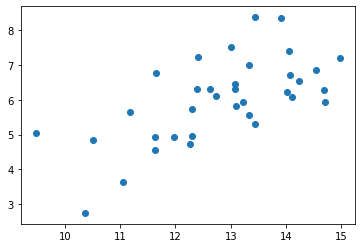

In [54]:
plt.scatter(x_try['tmax'],x_try['tmin'])

In [15]:
# Clustering using data cleaned of ouliers and null values
clstg=pd.read_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\Cleaned_data\cleaned_outlier_weather_data.txt', sep='\t')

In [16]:
x_try1=clstg.drop(['year','month'],axis=1)
x_try1.info()
x_try1=x_try1.groupby('class')['tmax','tmin','airfrost_days','total_rain','total_sunhours'].mean().reset_index()
x_try1.info()
x_try1.head()
x_try1 
le = LabelEncoder()
x_try1['class_code'] = le.fit_transform(x_try1['class'])
x_try1.head()
x_try1=x_try1.drop(['class'],axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24427 entries, 0 to 24426
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tmax            24427 non-null  float64
 1   tmin            24427 non-null  float64
 2   airfrost_days   24427 non-null  float64
 3   total_rain      24427 non-null  float64
 4   total_sunhours  24427 non-null  float64
 5   class           24427 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class           35 non-null     object 
 1   tmax            35 non-null     float64
 2   tmin            35 non-null     float64
 3   airfrost_days   35 non-null     float64
 4   total_rain      35 non-null     float64
 5   total_sunhours  35 non-null     float64
dtypes: float64(5)

C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# K means clustering on above data
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    print('\n for number of clusters=',n_clusters)
    kmeans = KMeans(n_clusters, random_state=1000)  
    model=kmeans.fit(x_try1)
    cluster_labels=kmeans.predict(x_try1)
    c=kmeans.cluster_centers_
    print('\n cluster centers are',c)
    print('Cluster labels are:',cluster_labels)
    print('Total number of cluster labels-',len(cluster_labels))
    sil=silhouette_score(x_try1,cluster_labels,metric='euclidean',sample_size=len(x_try1))
    print('silhouette score is:',sil)
    print('Inertia is:',kmeans.inertia_)


 for number of clusters= 2

 cluster centers are [[ 12.20590615   6.03758018   2.80368578 113.34216754 107.93879417
   15.375     ]
 [ 13.6755268    6.56553473   2.8490212   59.82595157 128.25894083
   17.48148148]]
Cluster labels are: [1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1]
Total number of cluster labels- 35
silhouette score is: 0.4708422221063803
Inertia is: 20368.4498057702

 for number of clusters= 3

 cluster centers are [[ 14.08199895   6.92310503   2.48429568  57.6811126  133.27570108
   18.81818182]
 [ 12.1346593    5.78557757   3.11324574  82.58875854 109.28810419
   15.5       ]
 [ 11.91196762   5.13533098   4.52203206 142.3886567  100.51843009
    8.66666667]]
Cluster labels are: [0 1 1 1 0 0 1 2 2 0 0 2 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0]
Total number of cluster labels- 35
silhouette score is: 0.37083313908304033
Inertia is: 14069.496066594045

 for number of clusters= 4

 cluster centers are [[ 14.69431174   8.05714592   1.349275

In [ ]:
#---------------------------------------------------
# Seasonal CLUSTERING
#---------------------------------------------------

In [19]:
# Working with data that has been imputed with mean
g1 = pd.read_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\Cleaned_data\cleaned_imputed_weather_data.txt', sep='\t')
g1.head()

,year,month,tmax,tmin,airfrost_days,total_rain,total_sunhours,class
0,1942,1,5.8,2.1,1.56,114.0,58.0,aberporth
1,1942,2,4.2,-0.6,1.56,13.8,80.3,aberporth
2,1942,3,9.7,3.7,1.56,58.0,117.9,aberporth
3,1942,4,13.1,5.3,1.56,42.5,200.1,aberporth
4,1942,5,14.0,6.9,1.56,101.1,215.1,aberporth


In [21]:
# Summer Clustering

#Clustering after filling missing data with mean values
summer_months=[3,4,5]
summer_data=g1[g1['month'].isin(summer_months)]
summer_data=summer_data.drop(['year'],axis=1)
summer_data=summer_data.groupby(['class','month']).aggregate({'tmax': 'max','tmin': 'max','airfrost_days':'min',
                                        'total_rain':'min','total_sunhours':'max'}).reset_index()
summer_data=summer_data.drop(['month'],axis=1)
summer_data=summer_data.groupby(['class'],as_index=True).aggregate({'tmax': 'max','tmin': 'max','airfrost_days':'min',
                                        'total_rain':'min','total_sunhours':'max'}).reset_index()
summer_data
#Label encoding
le = LabelEncoder()
summer_data['class_code'] = le.fit_transform(summer_data['class'])
summer_data.head()
summer_data=summer_data.drop(['class'],axis=1)
summer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tmax            37 non-null     float64
 1   tmin            37 non-null     float64
 2   airfrost_days   37 non-null     float64
 3   total_rain      37 non-null     float64
 4   total_sunhours  37 non-null     float64
 5   class_code      37 non-null     int32  
dtypes: float64(5), int32(1)
memory usage: 1.7 KB


In [22]:
# Kmeans-seasonal clustering for Summer
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    print('\n for number of clusters=',n_clusters)
    kmeans = KMeans(n_clusters, random_state=1000)  
    model=kmeans.fit(summer_data)
    cluster_labels=kmeans.predict(summer_data)
    c=kmeans.cluster_centers_
    #print('\n cluster centers are',c)
    print('Cluster labels are:',cluster_labels)
    print('Total number of cluster labels-',len(cluster_labels))
    sil=silhouette_score(summer_data,cluster_labels,metric='euclidean',sample_size=len(summer_data))
    print('silhouette score is:',sil)
    print('Inertia is:',kmeans.inertia_)


 for number of clusters= 2
Cluster labels are: [1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0]
Total number of cluster labels- 37
silhouette score is: 0.4739825987464966
Inertia is: 11415.646133333335

 for number of clusters= 3
Cluster labels are: [2 0 2 0 0 2 0 0 2 0 0 0 1 0 1 1 0 0 2 1 0 0 2 0 0 2 0 2 1 2 0 1 2 2 2 0 2]
Total number of cluster labels- 37
silhouette score is: 0.40096102661270283
Inertia is: 7556.063333333334

 for number of clusters= 4
Cluster labels are: [0 3 0 3 0 0 0 0 0 3 0 3 1 0 1 1 0 3 2 1 3 3 2 3 3 2 3 2 1 2 3 1 2 2 2 3 2]
Total number of cluster labels- 37
silhouette score is: 0.4026080572963749
Inertia is: 5289.614333333335

 for number of clusters= 5
Cluster labels are: [4 2 4 2 2 4 2 2 4 2 2 2 3 2 3 3 2 1 0 3 1 1 0 1 1 0 1 0 3 0 1 3 0 0 1 1 1]
Total number of cluster labels- 37
silhouette score is: 0.39615435719709013
Inertia is: 4148.094857142858

 for number of clusters= 6
Cluster labels are: [5 1 5 1 1 5 1 1 5 1 1 1 0 1 0 0 

[2 4 2 4 4 2 4 4 2 4 4 4 1 4 1 1 4 0 3 1 0 0 3 0 0 3 0 3 1 3 0 1 3 3 0 0 0]

silhouette score is: 0.37296059799959996


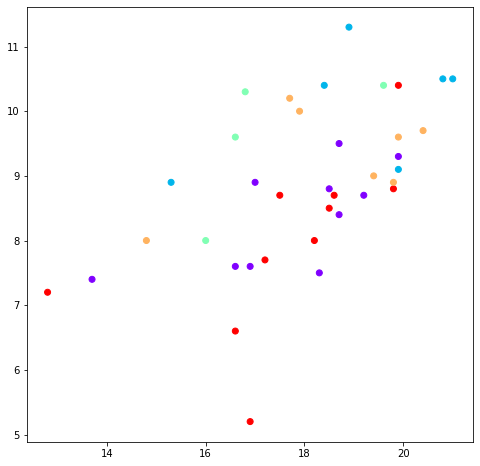

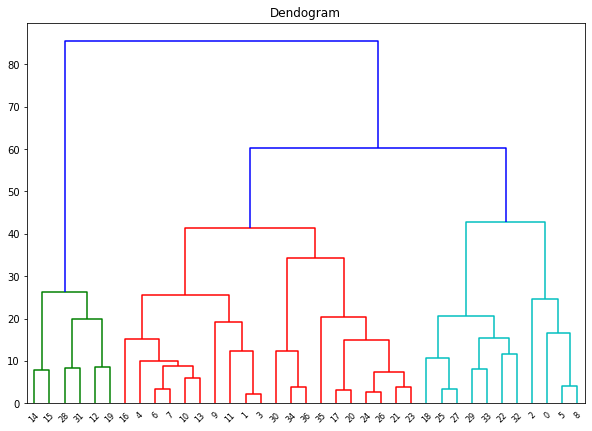

In [25]:
# Hierarchical clustering for summer
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
cluster.fit_predict(summer_data)
print(cluster.labels_)
sil=silhouette_score(summer_data,cluster_labels,metric='euclidean',sample_size=len(summer_data),random_state=1000)
print('\nsilhouette score is:',sil)
a=np.array(summer_data)
plt.figure(figsize=(8, 8))
plt.scatter(a[:,0],a[:,1], c=cluster.labels_, cmap='rainbow')
plt.show()

plt.figure(figsize=(10,7))
plt.title("Dendogram")
dend = dendrogram(linkage(summer_data, method='complete'))


In [26]:
# Winter Clustering

#Clustering after filling missing data with mean values
winter_months=[11,12,1,2]
winter_data=g1[g1['month'].isin(winter_months)]
winter_data=winter_data.drop(['year'],axis=1)
winter_data=winter_data.groupby(['class','month']).aggregate({'tmax': 'min','tmin': 'min','airfrost_days':'max',
                                        'total_rain':'max','total_sunhours':'min'}).reset_index()
winter_data=winter_data.drop(['month'],axis=1)
winter_data=winter_data.groupby(['class'],as_index=True).aggregate({'tmax': 'min','tmin': 'min','airfrost_days':'max',
                                                                    'total_rain':'max','total_sunhours':'min'}).reset_index()
#Label encoding
le = LabelEncoder()
winter_data['class_code'] = le.fit_transform(winter_data['class'])
winter_data.head()
winter_data=winter_data.drop(['class'],axis=1)
winter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tmax            37 non-null     float64
 1   tmin            37 non-null     float64
 2   airfrost_days   37 non-null     float64
 3   total_rain      37 non-null     float64
 4   total_sunhours  37 non-null     float64
 5   class_code      37 non-null     int32  
dtypes: float64(5), int32(1)
memory usage: 1.7 KB


In [27]:
# Kmeans-seasonal clustering for Winter
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    print('\n for number of clusters=',n_clusters)
    kmeans = KMeans(n_clusters, random_state=1000)  
    model=kmeans.fit(winter_data)
    cluster_labels=kmeans.predict(winter_data)
    c=kmeans.cluster_centers_
    #print('\n cluster centers are',c)
    print('Cluster labels are:',cluster_labels)
    print('Total number of cluster labels-',len(cluster_labels))
    sil=silhouette_score(winter_data,cluster_labels,metric='euclidean',sample_size=len(winter_data))
    print('silhouette score is:',sil)
    print('Inertia is:',kmeans.inertia_)


 for number of clusters= 2
Cluster labels are: [1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1]
Total number of cluster labels- 37
silhouette score is: 0.5872730043838803
Inertia is: 121598.91341269841

 for number of clusters= 3
Cluster labels are: [0 2 0 2 0 0 2 0 2 1 1 2 0 1 2 0 0 2 2 2 2 0 2 0 2 2 2 2 0 1 2 0 0 2 2 2 2]
Total number of cluster labels- 37
silhouette score is: 0.5382987327735342
Inertia is: 55718.94757692307

 for number of clusters= 4
Cluster labels are: [3 1 3 1 3 3 1 3 1 0 0 1 3 2 1 3 3 1 1 1 1 3 1 3 1 1 1 1 3 0 1 3 3 1 1 1 1]
Total number of cluster labels- 37
silhouette score is: 0.5352590644300246
Inertia is: 36034.075910256404

 for number of clusters= 5
Cluster labels are: [0 1 3 0 3 3 1 0 0 2 2 1 0 4 1 0 3 1 1 1 1 3 1 3 1 1 1 0 0 2 1 0 0 1 1 1 1]
Total number of cluster labels- 37
silhouette score is: 0.4716813990448446
Inertia is: 22556.963686274514

 for number of clusters= 6
Cluster labels are: [5 3 1 5 1 1 0 5 5 4 4 3 5 2 3 5 

[2 0 1 2 1 1 0 2 2 4 4 0 2 3 0 2 1 0 0 0 0 1 0 1 0 0 0 0 2 4 0 2 2 0 0 0 0]

silhouette score is: 0.3536886292367906


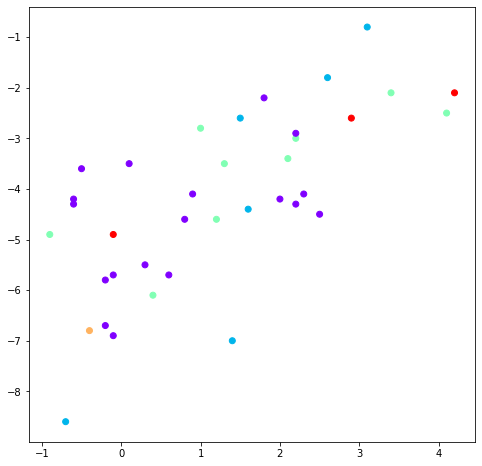

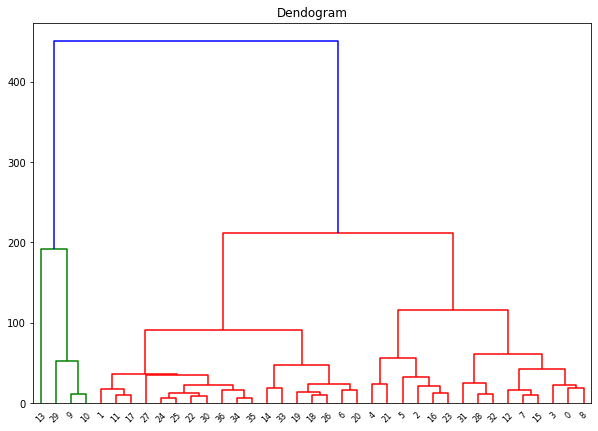

In [28]:
# Hierarchical clustering for winter
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
cluster.fit_predict(winter_data)
print(cluster.labels_)
sil=silhouette_score(winter_data,cluster_labels,metric='euclidean',sample_size=len(winter_data),random_state=1000)
print('\nsilhouette score is:',sil)
a=np.array(winter_data)
plt.figure(figsize=(8, 8))
plt.scatter(a[:,0],a[:,1], c=cluster.labels_, cmap='rainbow')
plt.show()

plt.figure(figsize=(10,7))
plt.title("Dendogram")
dend = dendrogram(linkage(winter_data, method='complete'))


In [ ]:
#---------------------------------------------------
# Extreme weather CLUSTERING
#---------------------------------------------------

In [29]:
#Clustering by taking extreme weather values for each station
extreme_data=g1.groupby(['year','class','month'])['tmax','tmin','airfrost_days','total_rain','total_sunhours'].max().reset_index()
extreme_data=extreme_data.drop(['year'],axis=1)
extreme_data=extreme_data.sort_values(by=['class','month'])
extreme_data = extreme_data.reset_index(drop=True)
extreme_data=extreme_data.drop(['month'],axis=1)
extreme_data=g1.groupby(['class'])['tmax','tmin','airfrost_days','total_rain','total_sunhours'].max().reset_index()
le = LabelEncoder()
extreme_data['class_code'] = le.fit_transform(extreme_data['class'])
extreme_data.head()
extreme_data=extreme_data.drop(['class'],axis=1)
extreme_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tmax            37 non-null     float64
 1   tmin            37 non-null     float64
 2   airfrost_days   37 non-null     float64
 3   total_rain      37 non-null     float64
 4   total_sunhours  37 non-null     float64
 5   class_code      37 non-null     int32  
dtypes: float64(5), int32(1)
memory usage: 1.7 KB


C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [30]:
# Kmeans-seasonal clustering for extreme data
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    print('\n for number of clusters=',n_clusters)
    kmeans = KMeans(n_clusters, random_state=1000)  
    model=kmeans.fit(extreme_data)
    cluster_labels=kmeans.predict(extreme_data)
    c=kmeans.cluster_centers_
    print('Cluster labels are:',cluster_labels)
    print('Total number of cluster labels-',len(cluster_labels))
    sil=silhouette_score(extreme_data,cluster_labels,metric='euclidean',sample_size=len(extreme_data))
    print('silhouette score is:',sil)
    print('Inertia is:',kmeans.inertia_)


 for number of clusters= 2
Cluster labels are: [0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Total number of cluster labels- 37
silhouette score is: 0.6151999132511335
Inertia is: 129083.85727272727

 for number of clusters= 3
Cluster labels are: [0 2 0 0 0 0 2 0 0 1 1 2 0 1 2 0 0 2 2 0 2 0 2 0 2 2 2 0 0 1 2 0 0 2 2 2 2]
Total number of cluster labels- 37
silhouette score is: 0.4650430673966783
Inertia is: 70248.52198529411

 for number of clusters= 4
Cluster labels are: [1 2 3 1 3 1 2 1 1 0 0 2 1 0 2 1 3 2 2 1 2 3 2 3 2 2 2 3 1 3 2 1 1 2 2 2 2]
Total number of cluster labels- 37
silhouette score is: 0.4769235825202891
Inertia is: 46473.13474567099

 for number of clusters= 5
Cluster labels are: [4 1 3 4 3 4 1 4 4 0 0 1 4 2 1 4 3 1 1 4 1 3 1 3 1 1 1 3 4 0 1 4 4 1 1 1 1]
Total number of cluster labels- 37
silhouette score is: 0.49351636982949
Inertia is: 29285.86950757576

 for number of clusters= 6
Cluster labels are: [4 5 3 4 3 4 1 4 4 0 0 1 4 2 1 4 3 5 

[1 0 4 1 4 1 0 1 1 3 3 1 1 2 0 1 4 0 0 1 0 4 0 4 0 0 0 1 1 3 0 1 1 1 0 0 0]

silhouette score is: 0.42062352998442337


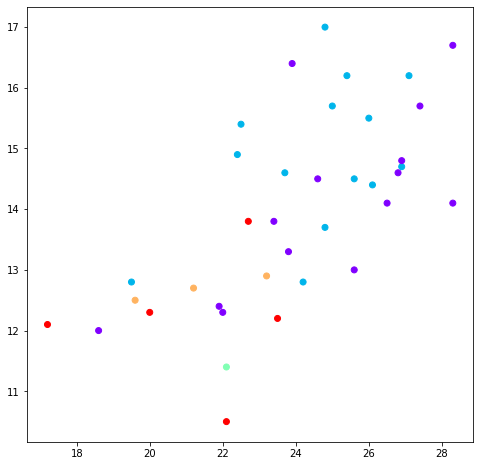

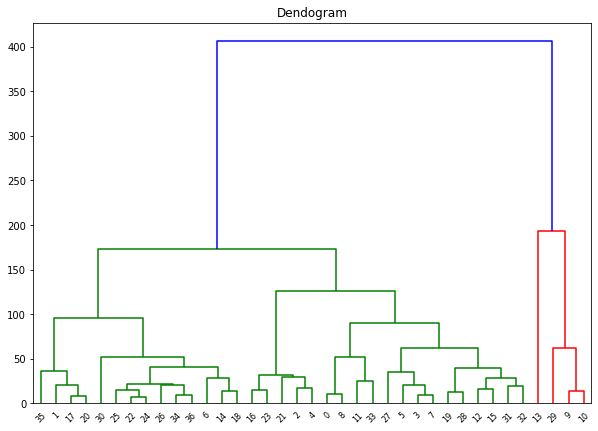

In [31]:
# Hierarchical clustering for extreme weather
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
cluster.fit_predict(extreme_data)
print(cluster.labels_)
sil=silhouette_score(extreme_data,cluster_labels,metric='euclidean',sample_size=len(extreme_data),random_state=1000)
print('\nsilhouette score is:',sil)
a=np.array(extreme_data)
plt.figure(figsize=(8, 8))
plt.scatter(a[:,0],a[:,1], c=cluster.labels_, cmap='rainbow')
plt.show()

plt.figure(figsize=(10,7))
plt.title("Dendogram")
dend = dendrogram(linkage(extreme_data, method='complete'))

In [ ]:
#--------------------------------------------------------------
# Understanding the performance of the clustering algorithms
#--------------------------------------------------------------

In [ ]:
#Check the data statistics

#Check statistics in the data used for ideal clustering
print('Summary statistics and variance of data used for ideal/normal clustering \n')
print(statistics.variance(x_try['tmax']))
print(statistics.variance(x_try['tmin']))
print(statistics.variance(x_try['airfrost_days']))
print(statistics.variance(x_try['total_rain']))
print(statistics.variance(x_try['total_sunhours']))
print(x_try.describe())

#Check statistics in the data used for seasonal clustering-summer
print('Summary statistics and variance of data used for seasonal weather clustering-summer \n')
print(statistics.variance(summerdata['tmax']))
print(statistics.variance(summerdata['tmin']))
print(statistics.variance(summerdata['airfrost_days']))
print(statistics.variance(summerdata['total_rain']))
print(statistics.variance(summerdata['total_sunhours']))
print(summerdata.describe())

#Check statistics in the data used for seasonal clustering-winter
print('Summary statistics and variance of data used for seasonal weather clustering-winter \n')
print(statistics.variance(winterdata['tmax']))
print(statistics.variance(winterdata['tmin']))
print(statistics.variance(winterdata['airfrost_days']))
print(statistics.variance(winterdata['total_rain']))
print(statistics.variance(winterdata['total_sunhours']))
print(winterdata.describe())

#Check statistics in the data used for extreme clustering
print('Summary statistics and variance of data used for extreme weather clustering \n')
print(statistics.variance(extreme_data['tmax']))
print(statistics.variance(extreme_data['tmin']))
print(statistics.variance(extreme_data['airfrost_days']))
print(statistics.variance(extreme_data['total_rain']))
print(statistics.variance(extreme_data['total_sunhours']))
print(extreme_data.describe())

In [ ]:
#-----------------------------------------------------------------------------------------------
# PART-2-Classification
#-----------------------------------------------------------------------------------------------

In [32]:
# Read csv file which has the cleaned data for classification(includes appended latitude column )
clsn_data=pd.read_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\Cleaned_data\classification_data.txt', sep='\t')
clsn_data.latitude=clsn_data.latitude.round(2)
clsn_data.head()

,year,month,tmax,tmin,airfrost_days,total_rain,total_sunhours,class,latitude
0,1942,1,5.8,2.1,1.56,114.0,58.0,aberporth,52.14
1,1942,2,4.2,-0.6,1.56,13.8,80.3,aberporth,52.14
2,1942,3,9.7,3.7,1.56,58.0,117.9,aberporth,52.14
3,1942,4,13.1,5.3,1.56,42.5,200.1,aberporth,52.14
4,1942,5,14.0,6.9,1.56,101.1,215.1,aberporth,52.14


In [33]:
# Divide data based on latitude values to append the region column

southern_data = clsn_data[clsn_data.loc[:,'latitude'].between(49.90,53.66)]
southern_data.loc[:,'region']='Southern UK'
central_data = clsn_data[clsn_data.loc[:,'latitude'].between(53.67,57.23)]
central_data.loc[:,'region']='Central UK'
northern_data = clsn_data[clsn_data.loc[:,'latitude'].between(57.24,60.90)]
northern_data.loc[:,'region']='Northern UK'
northern_data.info()
#Dataframe with appended region column
clsn_data=pd.concat([southern_data, central_data, northern_data],ignore_index=True) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4044 entries, 13270 to 30166
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            4044 non-null   int64  
 1   month           4044 non-null   int64  
 2   tmax            4044 non-null   float64
 3   tmin            4044 non-null   float64
 4   airfrost_days   4044 non-null   float64
 5   total_rain      4044 non-null   float64
 6   total_sunhours  4044 non-null   float64
 7   class           4044 non-null   object 
 8   latitude        4044 non-null   float64
 9   region          4044 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 347.5+ KB


C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [34]:
# Group data to get representative data for each station

ext_data=clsn_data.drop(['latitude'],axis=1) # Drop latitude because we need only weather data
ext_data=ext_data.groupby(['year','class','month','region'])['tmax','tmin','airfrost_days','total_rain','total_sunhours'].mean().reset_index()
ext_data=ext_data.drop(['year'],axis=1)
ext_data=ext_data.sort_values(by=['class','month'])
ext_data = ext_data.reset_index(drop=True)
ext_data=ext_data.drop(['month'],axis=1)
ext_data=ext_data.groupby(['class','region'])['tmax','tmin','airfrost_days','total_rain','total_sunhours'].mean().reset_index()
#ext_data
le = LabelEncoder()
ext_data['region_code'] = le.fit_transform(ext_data['region'])
ext_data.head()
ext_data=ext_data.drop(['region'],axis=1)
ext_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class           37 non-null     object 
 1   tmax            37 non-null     float64
 2   tmin            37 non-null     float64
 3   airfrost_days   37 non-null     float64
 4   total_rain      37 non-null     float64
 5   total_sunhours  37 non-null     float64
 6   region_code     37 non-null     int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 2.0+ KB


C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


In [35]:
#Split data into training and test data
train_data=ext_data.drop(['class'],axis=1)
train_data.info()
X=train_data.drop(['region_code'],axis=1)
y=train_data['region_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tmax            37 non-null     float64
 1   tmin            37 non-null     float64
 2   airfrost_days   37 non-null     float64
 3   total_rain      37 non-null     float64
 4   total_sunhours  37 non-null     float64
 5   region_code     37 non-null     int32  
dtypes: float64(5), int32(1)
memory usage: 1.7 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000174E1A7BBC8>,
      dtype=object)

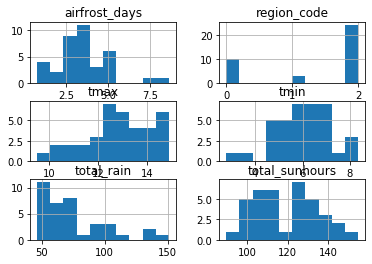

In [36]:
train_data.hist()

In [49]:
# Naive bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train) # train the model on training data
prediction_test = gnb.predict(X=X_test)
prediction_train = gnb.predict(X=X_train)
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train)))
cm = confusion_matrix(y_test, prediction_test,labels=[0,1,2])
print('\nConfusion matrix is:',cm)

Classification accuracy on test set: 0.600
Classification accuracy on training set: 0.864

Confusion matrix is: [[1 0 4]
 [1 0 1]
 [0 0 8]]


In [38]:
#Decision Tree Classifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)
dt.fit(X_train, y_train) # fit the model on training data
prediction_test = dt.predict(X=X_test)
prediction_train = dt.predict(X=X_train)
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train)))
cm = confusion_matrix(y_test, prediction_test)
print('\nConfusion matrix is:',cm)

Classification accuracy on test set: 0.667
Classification accuracy on training set: 0.955

Confusion matrix is: [[1 0 4]
 [1 1 0]
 [0 0 8]]


In [39]:
#Classification by splitting data manually

train_data2=train_data[:-5] #remove last 5 rows from the data
test_data2=train_data[-5:] # keep the last 5 rows

In [40]:
# Define training and test data
X_train2=train_data2.drop(['region_code'],axis=1) # just the weather data
y_train2=train_data2['region_code']  # region is the target column
X_test2=test_data2.drop(['region_code'],axis=1)
y_test2=test_data2['region_code']

In [55]:
#Naive bayes classifier
gnb = GaussianNB()
gnb.fit(X_train2, y_train2) # train the model on training data
prediction_test2 = gnb.predict(X=X_test2)
prediction_train2 = gnb.predict(X=X_train2)
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test2,prediction_test2)))
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train2,prediction_train2)))
cm = confusion_matrix(prediction_test2,y_test2)
print('Confusion matrix is:\n',cm)

Classification accuracy on test set: 0.800
Classification accuracy on training set: 0.875
Confusion matrix is:
 [[0 1 0]
 [0 0 0]
 [0 0 4]]


In [56]:
# Decision tree classifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)
dt.fit(X_train2, y_train2) # train the model
prediction_test2 = dt.predict(X=X_test2) # predict on test data
prediction_train2 = dt.predict(X=X_train2) # predict on training data
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test2,prediction_test2)))
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train2,prediction_train2)))
cm = confusion_matrix(prediction_test2,y_test2)
print('Confusion matrix is:\n',cm)

Classification accuracy on test set: 0.600
Classification accuracy on training set: 0.875
Confusion matrix is:
 [[0 1 1]
 [0 0 0]
 [0 0 3]]


In [ ]:
#--------------------------------------------------------------------------------
# PART-3-Happiness and weather relation
#--------------------------------------------------------------------------------

In [71]:
#Read excel file for 2015 happiness data

missing_values = ["n/a", "na", "---","  ","#","x"]
excel_data = pd.read_excel(r'C:\Users\USER\Desktop\assign3data\personal_wellbeingData\wellbeingdata_2015.xls',sheet_name='Happiness'
                   ,skiprows=6,header=None,index=None,na_values = missing_values,warn_bad_lines=False)
excel_data.head()
excel_data.columns=(['area_code','area_region','county','place','low%','medium%','high%','veryhigh%','average%','CL_Low_cv','CL_low_lowerlimit','CL_low_upperlimit','CL_medium _cv','CL_medium_lowerlimit','CL_medium_upperlimit',
'CL_high_cv','CL_high_lowerlimit','CL_high_upperlimit','CL_veryhigh_cv','CL_veryhigh_lowerlimit','CL_veryhigh_upperlimit','CL_avg_cv','CL_avg_lowerlimit','CL_avg_upperlimit','sample_size'])
excel_data=excel_data[:-16]

# Data cleaning
excel_data.loc[:,'area_region']=excel_data.loc[:,'area_region'].fillna(method='ffill')
excel_data.loc[:,'sample_size']=excel_data.loc[:,'sample_size'].fillna(0)
excel_data=excel_data.astype({'area_code':str,'area_region':str,'county':str,'place':str,'low%':float,'medium%':float,'high%':float,
                              'veryhigh%':float,'average%':float,'CL_Low_cv':float,'CL_low_lowerlimit':float,'CL_low_upperlimit':float,
                              'CL_medium _cv':float,'CL_medium_lowerlimit':float,'CL_medium_upperlimit':float,
                              'CL_high_cv':float,'CL_high_lowerlimit':float,'CL_high_upperlimit':float,'CL_veryhigh_cv':float,'CL_veryhigh_lowerlimit':float,'CL_veryhigh_upperlimit':float,
                              'CL_avg_cv':float,'CL_avg_lowerlimit':float,'CL_avg_upperlimit':float,'sample_size':int})
excel_data.isnull().any()
excel_data=excel_data.dropna()


In [72]:
# Extract relevant happiness data for the task
hap_data=excel_data[['area_code','area_region','county','place','low%',
                     'medium%','high%','veryhigh%','average%','sample_size']]
hap_data
hap_data['area_region']=hap_data['area_region'].replace('\d','',regex=True)

#Read regions file to append latitude to happiness data

region_data=pd.read_csv(r'C:\Users\USER\Desktop\assign3data\region.txt', sep=',',header=None)
region_data
region_data.columns=(['area_code','area_region','lat','lon'])
region_data=region_data.drop(['lon','area_code'],axis=1)

#Concatening dataframes to get final happiness data with latitudes
happiness_df=pd.merge(region_data,hap_data,on='area_region',how='inner')
happiness_df['lat']=happiness_df['lat'].round(decimals=0)
happiness_df=happiness_df.drop(['county','place','area_code'],axis=1)
happiness_df.rename({'lat':'latitude'}, axis=1,inplace=True)
happiness_df


C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,area_region,latitude,low%,medium%,high%,veryhigh%,average%,sample_size
0,NORTH EAST,55.0,10.77,17.05,39.06,33.13,7.34,11310
1,NORTH EAST,55.0,10.84,17.04,37.76,34.36,7.37,890
2,NORTH EAST,55.0,9.76,15.43,38.68,36.13,7.46,1000
3,NORTH EAST,55.0,10.14,15.41,38.48,35.97,7.48,1160
4,NORTH EAST,55.0,12.17,17.23,38.06,32.54,7.28,1060
...,...,...,...,...,...,...,...,...
182,SCOTLAND,56.0,8.93,14.23,42.12,34.72,7.56,610
183,SCOTLAND,56.0,11.63,18.79,39.80,29.78,7.20,740
184,SCOTLAND,56.0,9.14,14.37,45.99,30.50,7.44,790
185,NORTHERN IRELAND,55.0,6.76,14.66,37.57,41.00,7.75,2540


In [73]:
happiness_df['latitude'].unique()

array([55., 54., 53., 52., 51., 56.])

In [74]:
#Load (cleaned)weather data -data with appended latitudes to merge with happiness data

clsn_data=pd.read_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\Cleaned_data\classification_data.txt', sep='\t')
clsn_data['latitude']=clsn_data['latitude'].round(decimals=0)

# Merge data and Write to CSV
combined_data=pd.merge(clsn_data,happiness_df,on='latitude',how='inner')
combined_data.to_csv(r'C:\Users\USER\Desktop\assign3data\weather_data\cleaned_data\happiness_weather_combined_data.txt',sep='\t',header=True,index=False)


In [75]:
#Grouping happiness data
happiness_df=happiness_df.groupby(['area_region','latitude']).aggregate({'low%':min,'medium%':min,
                                                                        'high%':max,'veryhigh%':max,'average%':max,'sample_size':max}).reset_index()
happiness_df=happiness_df.sort_values(by=['latitude'])
happiness_df
#Grouping weather data
weathr_data=clsn_data.groupby(['year','class','month','latitude'])['tmax','tmin','airfrost_days','total_rain','total_sunhours'].max().reset_index()
weathr_data
weathr_data=weathr_data.drop(['year'],axis=1)
weathr_data=weathr_data.sort_values(by=['class','month'])
weathr_data=weathr_data.reset_index(drop=True)
weathr_data
weathr_data=weathr_data.drop(['month'],axis=1)
weathr_data=weathr_data.groupby(['class','latitude'])['tmax','tmin','airfrost_days','total_rain','total_sunhours'].max().reset_index()
weathr_data
weathr_data=weathr_data.drop(['class'],axis=1)
weathr_data
weathr_data=weathr_data.groupby(['latitude'])['tmax','tmin','airfrost_days','total_rain','total_sunhours'].max().reset_index()
weathr_data

C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\USER\Miniconda3\envs\novoic\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,latitude,tmax,tmin,airfrost_days,total_rain,total_sunhours
0,50.0,22.5,15.4,19.0,276.7,308.4
1,51.0,28.3,17.0,31.0,316.8,350.3
2,52.0,28.3,15.7,30.0,425.4,342.1
3,53.0,26.5,14.6,30.0,285.6,341.4
4,54.0,24.8,13.7,28.0,261.4,300.1
5,55.0,24.2,12.8,28.0,568.8,297.0
6,56.0,22.7,13.8,26.0,417.8,329.1
7,58.0,19.6,12.5,28.0,377.5,294.1
8,60.0,17.2,12.1,25.0,302.4,271.5


In [76]:
# Merged weather and happiness data
part3_final_df=pd.merge(weathr_data,happiness_df,on='latitude',how='inner')

In [78]:
corr_data=part3_final_df[['tmax','tmin','airfrost_days','total_rain','total_sunhours','area_region',
                              'low%','medium%','high%','veryhigh%']]

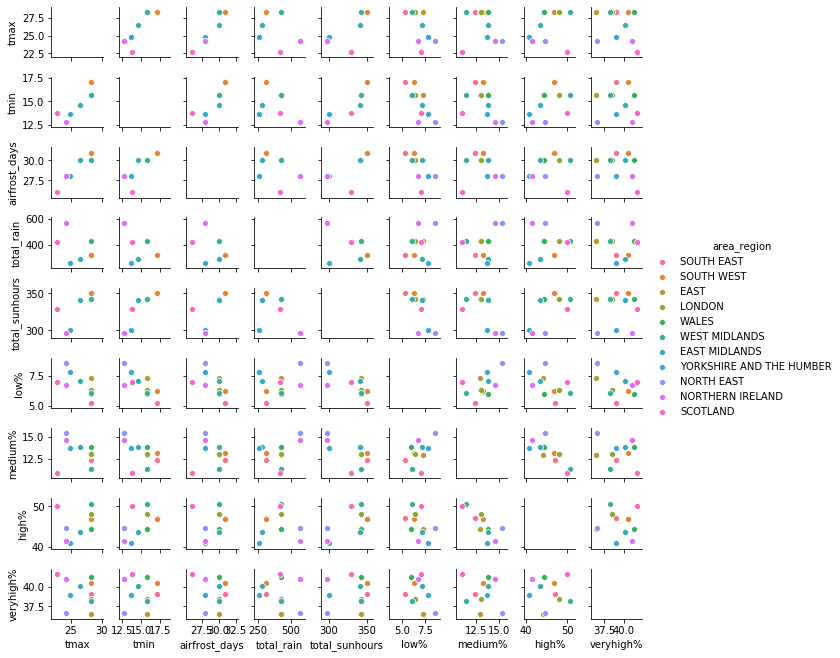

In [90]:
#Visualize the merged data
warnings.filterwarnings('ignore')
sns.pairplot(corr_data,hue='area_region',size=1)
figsize=(15,15)
plt.show()

In [79]:
corr_data.corr()

,tmax,tmin,airfrost_days,total_rain,total_sunhours,low%,medium%,high%,veryhigh%
tmax,1.000000,0.885875,0.943440,-0.325053,0.783669,-0.643017,-0.166580,0.239807,-0.243446
tmin,0.885875,1.000000,0.842812,-0.512429,0.910214,-0.763556,-0.443975,0.448166,-0.023534
airfrost_days,0.943440,0.842812,1.000000,-0.380100,0.714565,-0.599058,0.012127,0.098559,-0.212549
total_rain,-0.325053,-0.512429,-0.380100,1.000000,-0.474139,0.268697,0.334773,0.007714,-0.176450
total_sunhours,0.783669,0.910214,0.714565,-0.474139,1.000000,-0.722450,-0.567646,0.575209,0.092769
low%,-0.643017,-0.763556,-0.599058,0.268697,-0.722450,1.000000,0.502763,-0.452622,-0.382214
medium%,-0.166580,-0.443975,0.012127,0.334773,-0.567646,0.502763,1.000000,-0.784461,-0.184483
high%,0.239807,0.448166,0.098559,0.007714,0.575209,-0.452622,-0.784461,1.000000,0.002891
veryhigh%,-0.243446,-0.023534,-0.212549,-0.176450,0.092769,-0.382214,-0.184483,0.002891,1.000000


In [91]:
corr_data.corr(method='spearman')

,tmax,tmin,airfrost_days,total_rain,total_sunhours,low%,medium%,high%,veryhigh%
tmax,1.000000,0.879200,0.881638,-0.102233,0.879200,-0.621283,-0.313127,0.268394,-0.303186
tmin,0.879200,1.000000,0.908661,-0.317308,1.000000,-0.724584,-0.537595,0.458124,-0.032723
airfrost_days,0.881638,0.908661,1.000000,-0.273095,0.908661,-0.642130,-0.197950,0.217262,-0.144841
total_rain,-0.102233,-0.317308,-0.273095,1.000000,-0.317308,0.032723,0.266460,0.140242,-0.210363
total_sunhours,0.879200,1.000000,0.908661,-0.317308,1.000000,-0.724584,-0.537595,0.458124,-0.032723
low%,-0.621283,-0.724584,-0.642130,0.032723,-0.724584,1.000000,0.400000,-0.490909,-0.372727
medium%,-0.313127,-0.537595,-0.197950,0.266460,-0.537595,0.400000,1.000000,-0.700000,0.009091
high%,0.268394,0.458124,0.217262,0.140242,0.458124,-0.490909,-0.700000,1.000000,-0.027273
veryhigh%,-0.303186,-0.032723,-0.144841,-0.210363,-0.032723,-0.372727,0.009091,-0.027273,1.000000


In [ ]:
#-----------------------------------------------------------------------------------------------------------